### Imports

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
import time
from array import array
from scipy.interpolate import interp1d
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
import itertools
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
import operator
ops = {'>': operator.gt, '<': operator.lt, '=': operator.eq, '==': operator.eq}

In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

In [6]:
statMethod = rt.TEfficiency.kFCP

# Load data

In [7]:
trigger = 'HLT_Mu9_IP6'

In [8]:
effLoc = '../data/calibration/triggerScaleFactors/' + trigger
finRD = rt.TFile(effLoc + '_RD.root', 'READ')
effRD = finRD.Get('eff_' + trigger)
effRD.SetStatisticOption(statMethod)
finMC = rt.TFile(effLoc + '_MC.root', 'READ')
effMC = finMC.Get('eff_' + trigger)
effMC.SetStatisticOption(statMethod)

In [9]:
def recomputeEffErr(idx, pEff):
    nT = pEff.GetTotalHistogram().GetBinContent(idx)
    nP = pEff.GetPassedHistogram().GetBinContent(idx)
    eff = nP/float(nT)
    effUnc = np.sqrt((1-eff)*eff/nT)
    print 'Crude approx: {:.3f} +/- {:.3f}'.format(eff, effUnc)
    
    effTest = rt.TEfficiency('effTest', 'effTest;x;#epsilon', 1, 0, 1)
    effTest.SetStatisticOption(statMethod)
    effTest.SetTotalEvents(1, int(nT))
    effTest.SetPassedEvents(1, int(nP))
    print 'Recomputing...'
    print 'eff: {:.3f} -{:.3f} / + {:.3f}'.format(effTest.GetEfficiency(1),
                                                  effTest.GetEfficiencyErrorLow(1),
                                                  effTest.GetEfficiencyErrorUp(1))
    print '\n'
    return 0.5*(effTest.GetEfficiencyErrorLow(1) + effTest.GetEfficiencyErrorUp(1))

# Compute SF

In [10]:
hSF = effRD.GetCopyPassedHisto()
hSF.SetNameTitle('hSF_' + trigger, 'Scale factors for ' + trigger)
hSF.SetXTitle('Muon p_{T} [GeV]')
hSF.SetYTitle('Muon #sigma_{d_{xy}}/ d_{xy} (IP)')
hSF.SetZTitle('Muon #eta')
hSF.Reset()

In [11]:
for ix, iy, iz in itertools.product(range(1, hSF.GetNbinsX()+1), range(1, hSF.GetNbinsY()+1), range(1, hSF.GetNbinsZ()+1)):
    idx = hSF.GetBin(ix, iy, iz)
    if effMC.GetEfficiency(idx) == 0:
#         print 'Eff = 0 at [{}, {}, {}]'.format(ix, iy, iz)
        hSF.SetBinContent(idx, 0)
        hSF.SetBinError(idx, 0)
        continue
    
    sf = effRD.GetEfficiency(idx)/effMC.GetEfficiency(idx)
    if sf > 10:
#         print 'SF too high at [{}, {}, {}]'.format(ix, iy, iz)
        hSF.SetBinContent(idx, 0)
        hSF.SetBinError(idx, 0)
        continue
    hSF.SetBinContent(idx, sf)
    
    errRD = 0.5*(effRD.GetEfficiencyErrorLow(idx) + effRD.GetEfficiencyErrorUp(idx))
    if np.isnan(errRD):
        print 'nan RD uncertainty at [{}, {}, {}]'.format(ix, iy, iz)
        print 'Eff RD = {:.3f} -{:.3f} / +{:.3f}'.format(effRD.GetEfficiency(idx), 
                                                         effRD.GetEfficiencyErrorLow(idx), 
                                                         effRD.GetEfficiencyErrorUp(idx))
        errRD = recomputeEffErr(idx, effRD)
        
    if errRD > 0.1:
        print ix, iy, iz, errRD
    errRD /= effRD.GetEfficiency(idx)
    
    errMC = 0.5*(effMC.GetEfficiencyErrorLow(idx) + effMC.GetEfficiencyErrorUp(idx))
    if np.isnan(errMC):
        print 'nan MC uncertainty at [{}, {}, {}]'.format(ix, iy, iz)
        print 'Eff MC = {:.3f} -{:.3f} / +{:.3f}'.format(effMC.GetEfficiency(idx), 
                                                         effMC.GetEfficiencyErrorLow(idx), 
                                                         effMC.GetEfficiencyErrorUp(idx))
        errMC = recomputeEffErr(idx, effMC)
    if errMC > 0.1:
        print ix, iy, iz, errMC
    errMC /= effMC.GetEfficiency(idx)
    
    err_sf = sf*np.hypot(errMC, errRD)

    hSF.SetBinError(idx, err_sf)

fSF = rt.TFile(effLoc + '_SF.root', 'RECREATE')
hSF.Write()
fSF.Close()

nan RD uncertainty at [4, 4, 2]
Eff RD = 0.895 -nan / +nan
Crude approx: 0.895 +/- 0.004
Recomputing...
eff: 0.895 -0.004 / + 0.004


nan RD uncertainty at [5, 5, 3]
Eff RD = 0.900 -nan / +nan
Crude approx: 0.900 +/- 0.002
Recomputing...
eff: 0.900 -0.002 / + 0.002




To retrieve the SF value:

        ix = hSF.GetXaxis().FindBin(pt)
        iy = hSF.GetYaxis().FindBin(sigdxy)
        iz = hSF.GetZaxis().FindBin(abs(eta))
        w = hSF.GetBinContent(ix, iy, iz)

# Plot the SF

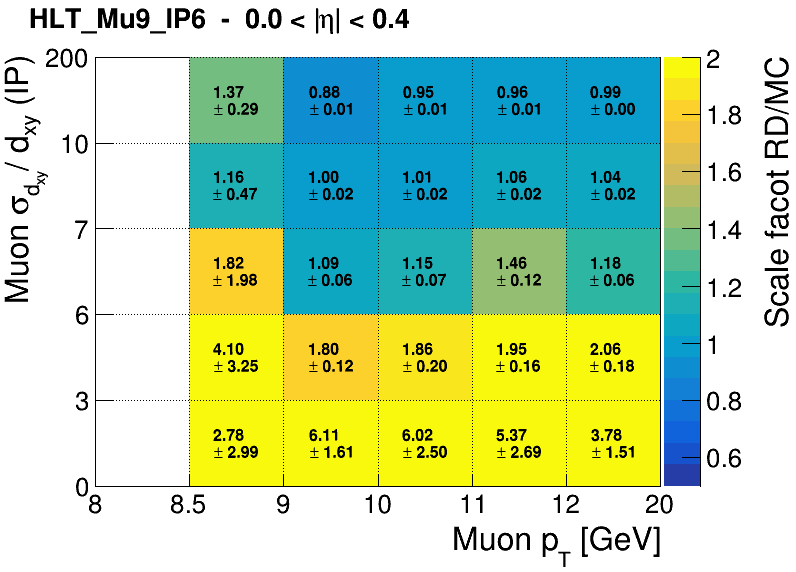

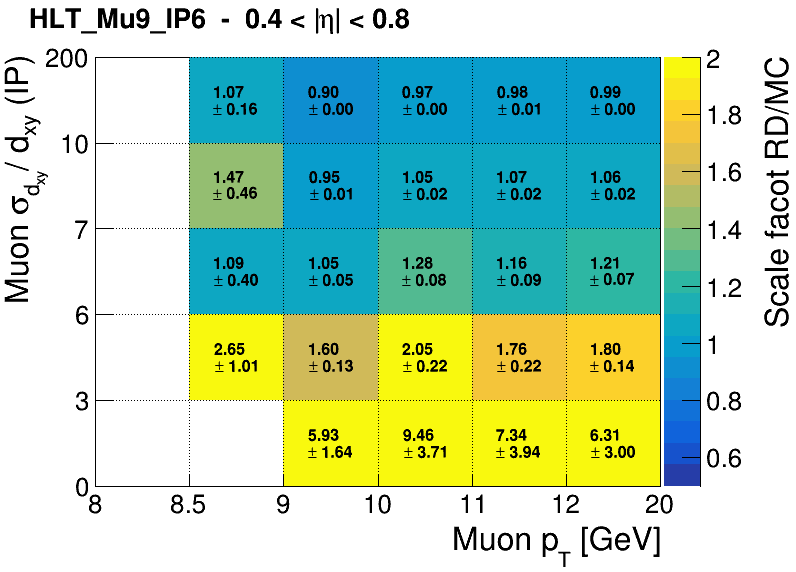

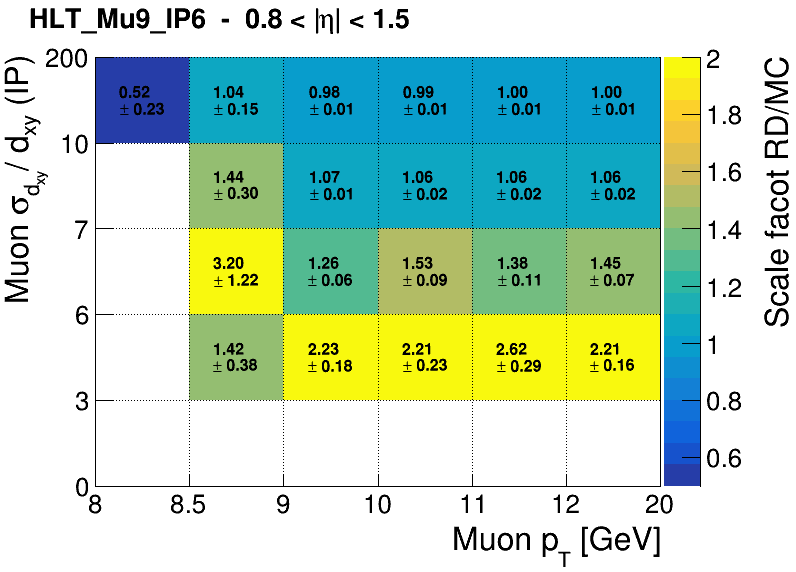

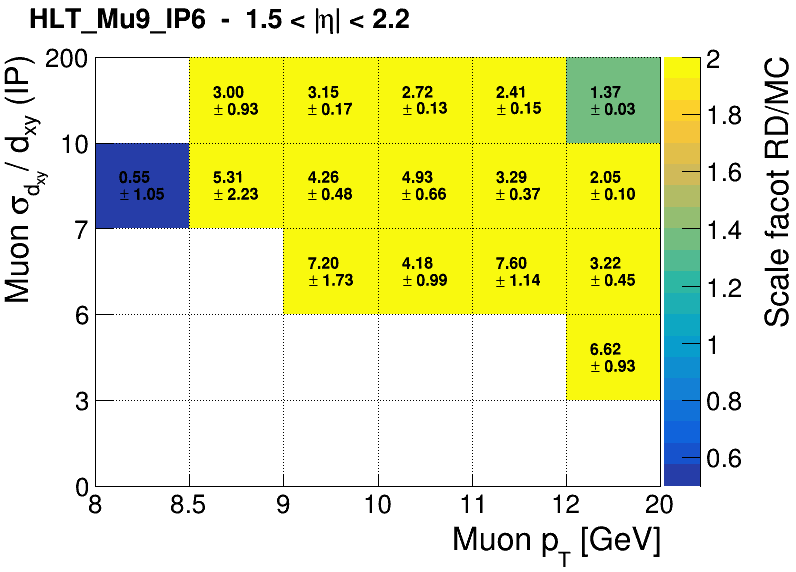

In [12]:
outCanvases = []
rt.gStyle.SetOptTitle(1)
rt.gStyle.SetTitleFillColor(0)
rt.gStyle.SetTitleBorderSize(0)
nx = hSF.GetNbinsX()
ny = hSF.GetNbinsY()

rt.gStyle.SetPaintTextFormat('.2f')
for iz in range(1, hSF.GetNbinsZ()+1):
    minEta = hSF.GetZaxis().GetBinCenter(iz) - 0.5*hSF.GetZaxis().GetBinWidth(iz)
    maxEta = hSF.GetZaxis().GetBinCenter(iz) + 0.5*hSF.GetZaxis().GetBinWidth(iz)
    title = '{}  -  {:.1f} < |#eta| < {:.1f}'.format(trigger, minEta, maxEta)
    
    h2 = rt.TH2D('h'+str(iz), title, nx, 0, nx, ny, 0, ny)
    h2.SetXTitle(hSF.GetXaxis().GetTitle())
    h2.SetYTitle(hSF.GetYaxis().GetTitle())
    h2.SetZTitle('Scale facot RD/MC')

    for iy in range(1, hSF.GetNbinsY()+1):
        for ix in range(1, hSF.GetNbinsX()+1):
            h2.SetBinContent(ix, iy, hSF.GetBinContent(ix, iy, iz))
            idx = hSF.GetBin(ix, iy, iz)
            h2.SetBinError(h2.GetBin(ix, iy), hSF.GetBinError(idx))
    h2.SetMarkerSize(1.5)
    h2.GetZaxis().SetRangeUser(0.5, 2)
    h2.GetYaxis().SetTitleOffset(0.9)
    h2.GetXaxis().SetTitleOffset(1.1)
    c = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'texte same'], tag=str(iz))
    c.SetTopMargin(0.1)
    c.SetBottomMargin(0.15)
    c.SetLeftMargin(0.12)
    c.SetRightMargin(0.17)
    
    ax = h2.GetYaxis()
    ax.SetNdivisions(-ny)
    for i in range(ny+2):
        l = hSF.GetYaxis().GetBinCenter(i) + 0.5*hSF.GetYaxis().GetBinWidth(i)
        if i == 0:
            l = hSF.GetYaxis().GetBinCenter(1) - 0.5*hSF.GetYaxis().GetBinWidth(1)            
        ax.ChangeLabel(i+1, -1, -1, -1, -1, -1, '{0:g}'.format(l))
    
    ax = h2.GetXaxis()
    ax.SetNdivisions(-nx)
    for i in range(nx+2):
        l = hSF.GetXaxis().GetBinCenter(i) + 0.5*hSF.GetXaxis().GetBinWidth(i)
        if i == 0:
            l = hSF.GetXaxis().GetBinCenter(1) - 0.5*hSF.GetXaxis().GetBinWidth(1)            
        ax.ChangeLabel(i+1, -1, -1, -1, -1, -1, '{0:g}'.format(l))
    
    imgLoc = '../data/calibration/triggerScaleFactors/figSF/'
    c.SaveAs(imgLoc + trigger + '_eta{}.png'.format(iz-1))
    c.SetGrid()
    outCanvases.append([c, h2])